### CNN Convolution Task

In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def get_preprocessed_data(images, targets):
    images = np.array(images / 255.0, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    
    return images, targets

def get_preprocessed_ohe(images, targets):
    images, targets = get_preprocessed_data(images, targets)
    oh_targets = to_categorical(targets)
    return images, oh_targets

def get_train_valid_test(train_images, train_targets, test_images, test_targets, validation_size=0.2, random_state=124):
    train_images, train_oh_targets = get_preprocessed_ohe(train_images, train_targets)
    test_images, test_oh_targets = get_preprocessed_ohe(test_images, test_targets)
    
    train_train_images, validation_images, train_train_oh_targets, validation_oh_targets = \
    train_test_split(train_images, train_oh_targets, stratify=train_oh_targets, test_size=validation_size, random_state=random_state)
    
    return (train_images, train_oh_targets), (validation_images, validation_oh_targets), (test_images, test_oh_targets)

In [2]:
from tensorflow.keras.datasets import mnist

(train_images, train_targets), (test_images, test_targets) = mnist.load_data()


(train_images, train_oh_targets), (validation_images, validation_oh_targets), (test_images, test_oh_targets) = \
get_train_valid_test(train_images, train_targets, test_images, test_targets)

print(train_images.shape, train_oh_targets.shape)
print(validation_images.shape, validation_oh_targets.shape)
print(test_images.shape, test_oh_targets.shape)

(60000, 28, 28) (60000, 10)
(12000, 28, 28) (12000, 10)
(10000, 28, 28) (10000, 10)


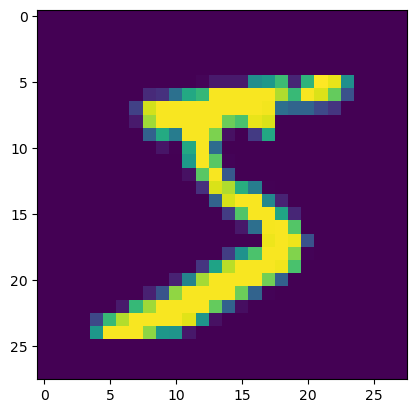

In [3]:
import matplotlib.pyplot as plt

plt.imshow(train_images[0])
plt.show()

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.models import Model

INPUT_SIZE = 28

input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE, 1))
# input = 1
# kernel = 3 * 3 = 9
# filter = 16
# 9 * 16 + 16 = 160

x = Conv2D(filters = 16, kernel_size= 3, strides=1, padding='same',activation='relu')(input_tensor)

# input = 16
# kernel = 4 * 4 = 16
# filter = 32
# 16 * 16 * 32 + 32 = 8224
x = Conv2D(filters = 32, kernel_size= 4, strides=1, padding='same',activation='relu')(x)

# input = 32
# kernel = 4 * 4 = 16
# filter = 64
# 32 * 16 * 64 + 64 = 32832

x = Conv2D(filters = 64, kernel_size= 4, strides=1,activation='relu')(x)

x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(50, activation='relu')(x)
x = Dense(20, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs= input_tensor, outputs = output)
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       460,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,296 (1.92 MB)

 Trainable params: 503,296 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model.compile(optimizer= Adam(0.001), loss = CategoricalCrossentropy(), metrics =['acc'])

history = model.fit(x=train_images, y=train_oh_targets, batch_size=64, epochs=5, 
                    validation_data = (validation_images, validation_oh_targets))

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 71s 75ms/step - acc: 0.8830 - loss: 0.3685 - val_acc: 0.9835 - val_loss: 0.0526
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 77s 82ms/step - acc: 0.9852 - loss: 0.0476 - val_acc: 0.9896 - val_loss: 0.0304
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 89s 95ms/step - acc: 0.9907 - loss: 0.0289 - val_acc: 0.9917 - val_loss: 0.0281
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 101s 108ms/step - acc: 0.9932 - loss: 0.0215 - val_acc: 0.9917 - val_loss: 0.0235
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 89s 95ms/step - acc: 0.9942 - loss: 0.0183 - val_acc: 0.9917 - val_loss: 0.0238


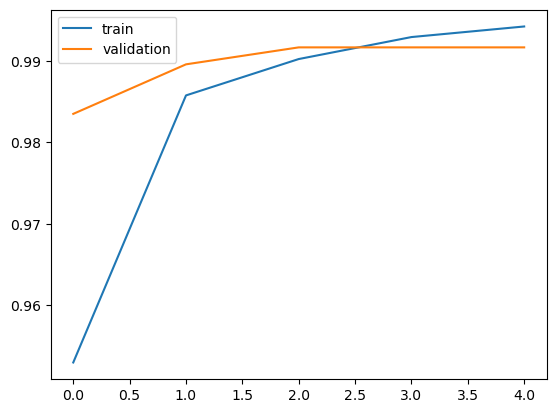

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.show()

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

INPUT_SIZE = 28

input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE, 1))


x = Conv2D(filters = 16, kernel_size= 3, strides=1, padding='same',activation='relu')(input_tensor)
x = Conv2D(filters = 32, kernel_size= 4, strides=1, padding='same',activation='relu')(x)
x = Conv2D(filters = 64, kernel_size= 4, strides=1,activation='relu')(x)

x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dense(20, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs= input_tensor, outputs = output)
model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │       460,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,296 (1.92 MB)

 Trainable params: 503,296 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model.compile(optimizer= Adam(0.001), loss = CategoricalCrossentropy(), metrics =['acc'])

history = model.fit(x=train_images, y=train_oh_targets, batch_size=64, epochs=5, 
                    validation_data = (validation_images, validation_oh_targets))

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 78s 83ms/step - acc: 0.8721 - loss: 0.3963 - val_acc: 0.9872 - val_loss: 0.0420
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 90s 96ms/step - acc: 0.9832 - loss: 0.0555 - val_acc: 0.9912 - val_loss: 0.0289
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 92s 98ms/step - acc: 0.9870 - loss: 0.0402 - val_acc: 0.9921 - val_loss: 0.0262
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 98s 105ms/step - acc: 0.9900 - loss: 0.0328 - val_acc: 0.9922 - val_loss: 0.0220
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 94s 100ms/step - acc: 0.9913 - loss: 0.0263 - val_acc: 0.9969 - val_loss: 0.0103


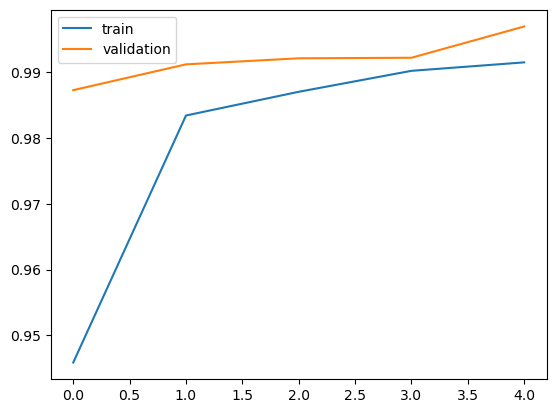

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.show()

In [9]:
# 테스트 데이터 세트로 모델 성능 검증
model.evaluate(test_images, test_oh_targets, batch_size=256, verbose=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - acc: 0.9898 - loss: 0.0292


[0.022559527307748795, 0.9926000237464905]